<a href="https://colab.research.google.com/github/pywang89/DM2023-Lab2-Master/blob/main/DM2023_Lab2_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Student Information
Name: 王斾頤

Student ID: 112065522

GitHub ID: 107053143

Kaggle name: pywang

Kaggle private scoreboard snapshot:

[Snapshot](img/pic0.png)
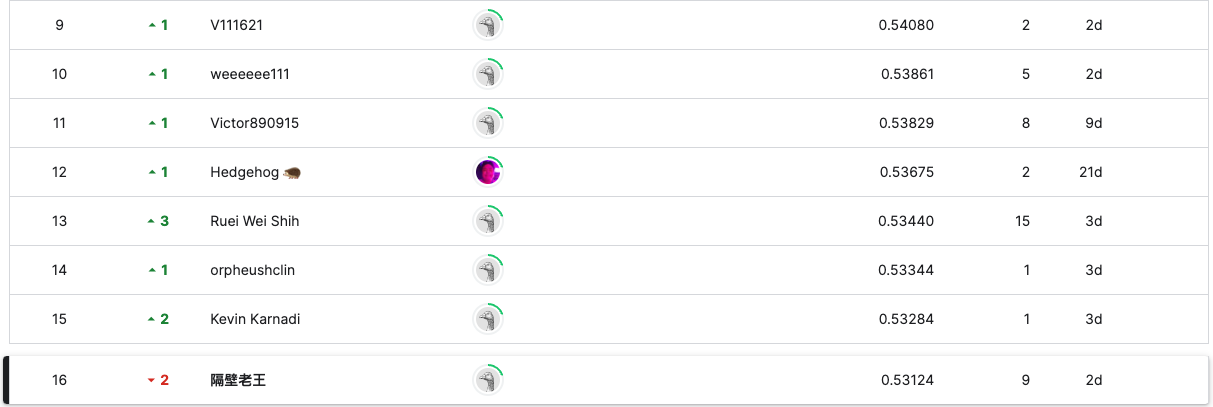

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the DM2023-Lab2-master. You may need to copy some cells from the Lab notebook to this notebook.


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2) regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2. The scoring will be given according to your place in the Private Leaderboard ranking:
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Dec. 27th 11:59 pm, Wednesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained.


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Dec. 31th 11:59 pm, Sunday)__.

In [ ]:
# Code for Google drive
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/Shareddrives/DMLab2/DMLab2/DM2023-Lab2-Master')
os.listdir()

data_path = "/content/drive/Shareddrives/DMLab2/DMLab2/DM2023-Lab2-Master/kaggle/"

# install package all we need
! pip install datasets
! pip install transformers
! pip install kaggle

In [2]:
# import all libraries
import pandas as pd
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import nltk
nltk.download('punkt')

import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax
from keras.callbacks import CSVLogger
from gensim.models import KeyedVectors

from datasets import Dataset, DatasetDict, load_from_disk
from datasets import Dataset, load_from_disk

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Part 1

In [3]:
### training data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [4]:
### testing data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [5]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)



## Exercise 1
Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)


In [6]:
# Answer here
count_vect = CountVectorizer()

def plot_top_words(data, title):
    X_counts = count_vect.fit_transform(data.text)
    # calculate the term frequencies and represented as a one-dimensional np.array
    term_frequencies = np.asarray(X_counts.sum(axis=0))[0]
    # buid a dataframe include terms and its frequencies
    df_all = pd.DataFrame({"term": count_vect.get_feature_names_out(), "frequency": term_frequencies})
    # find top 30 high-frequency words
    selected_terms = df_all.nlargest(30, "frequency")
    # plot
    fig = px.bar(selected_terms, x="term", y="frequency", text_auto='.2s', title=title)
    fig.update_xaxes(tickangle=90)
    fig.update_layout(xaxis_title="Term", yaxis_title="Frequency")
    fig.show()

# training dataset
plot_top_words(train_df, "Top 30 Words in Training Dataset")

# testing dataset
plot_top_words(test_df, "Top 30 Words in Testing Dataset")

#both training and testing dataset
both_df = pd.concat([train_df, test_df])
plot_top_words(both_df, "Top 30 Words in both Training and Testing Dataset")

## Exercise 2
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [7]:
# Answer here

# build analyzers (tf-idf 1000 features)
tfidf_1000 = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize)
# apply analyzer to training data
tfidf_1000.fit(train_df['text'])

train_data_tfidf_features_1000 = tfidf_1000.transform(train_df['text'])

# check dimension
print(train_data_tfidf_features_1000.shape)

feature_names_100_110 = tfidf_1000.get_feature_names_out()[100:110]
print("\nTrain data TF-IDF features [100:110]:")
print(feature_names_100_110)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



(3613, 1000)

Train data TF-IDF features [100:110]:
['awful' 'b' 'baby' 'back' 'bad' 'ball' 'balls' 'bb18' 'bc' 'bday']


## Exercise 3
Can you interpret the results above? What do they mean?

In [8]:
# Funciton for visualizing confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

training accuracy: 0.99
testing accuracy: 0.68
              precision    recall  f1-score   support

       anger       0.66      0.68      0.67        84
        fear       0.66      0.69      0.67       110
         joy       0.72      0.71      0.71        79
     sadness       0.70      0.64      0.67        74

    accuracy                           0.68       347
   macro avg       0.68      0.68      0.68       347
weighted avg       0.68      0.68      0.68       347



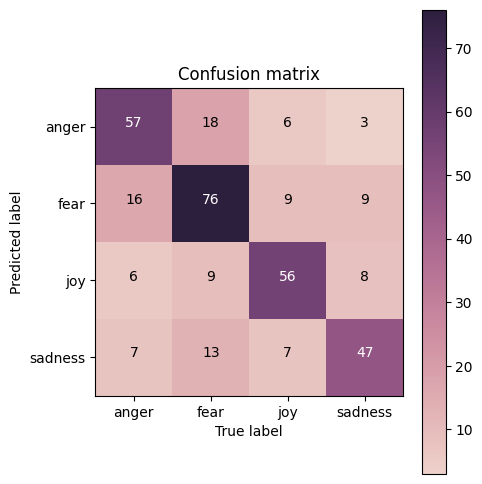

In [9]:
# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize)
# apply analyzer to training data
BOW_500.fit(train_df['text'])

# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)


# evaluation
acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))


print(classification_report(y_true=y_test, y_pred=y_test_pred))


# plot your confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

### Answer here
橫軸表示dataset提供的正確標籤，縱軸表示decision tree model的預測結果。

當`預測結果==實際標籤`表示分類正確，由上圖可知左上至右下對角線為正確的分類結果，其餘則為分類錯誤！

例如：`實際標籤==fear`，`預測標籤==anger`的值為18，表示模型將18個`fear`的數據錯誤地分類為`anger`。

從上面 confusion matrix 的繪圖，我們可以看出：
1. 圖中顏色越深，數值越大。相同標籤的對角線非常明顯，表示模型大致正確地進行了分類。
2. 在分類`fear`標籤方面，它的準確性最高，可以看到有76個正確的案例，遠高於其他標籤。
3. 左上角的顏色較深，這意味著模型對於`anger`和`fear`相較於其他標籤有較多的混淆。


---
## Exercise 4
Build a model using a ```Naive Bayes``` model and train it. What are the testing results?

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

training accuracy: 0.79
testing accuracy: 0.7
              precision    recall  f1-score   support

       anger       0.63      0.65      0.64        84
        fear       0.73      0.77      0.75       110
         joy       0.78      0.71      0.74        79
     sadness       0.64      0.62      0.63        74

    accuracy                           0.70       347
   macro avg       0.70      0.69      0.69       347
weighted avg       0.70      0.70      0.70       347



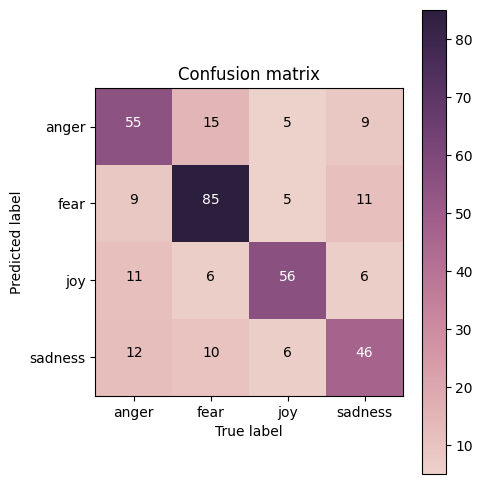

In [10]:
# Answer here
nb = MultinomialNB()
nb.fit(X_train, y_train)

# predict
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)


acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

print(classification_report(y_true=y_test, y_pred=y_test_pred))

my_tags = ['anger', 'fear', 'joy', 'sadness']
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')


1. `Naive Bayes`模型在 `fear` 標籤上取得了最佳結果，且數字比起`Decision Tree`來得高（85）。
2. 在 `anger` 和 `sadness` 上，`Naive Bayes`的precision和recall都較低，與`Decision Tree`相似。
3. 與先前`Decision Tree`結果相比，發現`Naive Bayes`對於`Prediction==anger`、`True Label==fear`的混淆仍然沒有降低。

---
## Exercise 5
How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

### Answer here
1.  `Decision Tree`是一種基於樹的演算法，目標是通過建立有效的分割路徑，以在每個節點處減少數據的不確定性。
2. `Naive Bayes`假設每個特徵之間都是獨立的，並將每個特徵視為獨立的分佈，根據每個特徵的概率狀態進行分類。

比較兩種模型的 precision、recall 和 F1-score，我們分開計算四種情緒間最高分數和對低分數的差距：
- Precision：0.06 (DT) \ 0.15 (NB)
- Recall：0.07 (DT) \ 0.15 (NB)
- F1-score：0.04 (DT) \ 0.12 (NB)

可以發現`Decision Tree`的結果較為一致，每種情緒分數之間的差距比`Naive Bayes`小!

這一差異源於`Decision Tree`的目標是通過降低數據的隨機性來提高整體效能，而`Naive Bayes`則獨立地慮每個特徵的可能性分佈。

此外，在兩者分類結果中，`fear`標籤的表現都較另外三種情緒出色。推測可能是該情緒中存在較多獨特的關鍵詞，這使得模型在看到這些詞時更有可能將文本歸類為 `fear`。

---
## Exercise 6
Plot the Training and Validation Accuracy and Loss (different plots), just like the images below.(Note: the pictures below are an example from a different model). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?
<table><tr>
    <td><img src="pics/pic3.png" style="width: 300px;"/> </td>
    <td><img src="pics/pic4.png" style="width: 300px;"/> </td>
</tr></table>

In [11]:
# standardize name (X, y)
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']
## check dimension is a good habbit
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

## deal with label (string -> one-hot)


label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


# I/O check
input_shape = X_train.shape[1]
output_shape = len(label_encoder.classes_)


# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)
check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert

y_train.shape:  (3613,)
y_test.shape:  (347,)


## After convert

y_train.shape:  (3613, 4)
y_test.shape:  (347, 4)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense (Dense)               (None, 64)                32064     
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 re_lu_1 (ReLU)              (None, 64)   

In [12]:
csv_logger = CSVLogger('logs/training_log.csv')

# training setting
epochs = 25 # means train same data for 25 times
batch_size = 32 # update avg loss by considering 32 data -> 32*113 = training data size

# training!
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/25
113/113 [==============================] - 2s 12ms/step - loss: 1.3299 - accuracy: 0.3629 - val_loss: 1.2831 - val_accuracy: 0.4352
Epoch 2/25
113/113 [==============================] - 0s 3ms/step - loss: 0.9934 - accuracy: 0.6358 - val_loss: 0.9537 - val_accuracy: 0.6167
Epoch 3/25
113/113 [==============================] - 0s 3ms/step - loss: 0.5792 - accuracy: 0.7891 - val_loss: 0.7839 - val_accuracy: 0.6888
Epoch 4/25
113/113 [==============================] - 0s 3ms/step - loss: 0.4085 - accuracy: 0.8508 - val_loss: 0.7675 - val_accuracy: 0.7003
Epoch 5/25
113/113 [==============================] - 0s 3ms/step - loss: 0.3260 - accuracy: 0.8854 - val_loss: 0.8399 - val_accuracy: 0.7061
Epoch 6/25
113/113 [==============================] - 0s 3ms/step - loss: 0.2613 - accuracy: 0.9098 - val_loss: 0.8522 - val_accuracy: 0.6772
Epoch 7/25
113/113 [==============================] - 0s 3ms/step - loss: 0.2215 - accuracy: 0.9231 - val_loss: 0.9347 - val_accuracy: 0.6888
Epoch

In [13]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result = label_decode(label_encoder, pred_result)
print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/training_log.csv")
training_log

3/3 [==============================] - 0s 3ms/step
testing accuracy: 0.67


,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.362856,1.329854,0.435158,1.283103
1,1,0.635760,0.993378,0.616715,0.953742
2,2,0.789095,0.579226,0.688761,0.783917
3,3,0.850816,0.408466,0.700288,0.767464
4,4,0.885414,0.325997,0.706052,0.839880
5,5,0.909770,0.261267,0.677233,0.852210
6,6,0.923056,0.221474,0.688761,0.934677
7,7,0.941323,0.184564,0.685879,0.940534
8,8,0.954885,0.154680,0.680115,1.021862
9,9,0.958760,0.139411,0.677233,1.059958


### Answer here

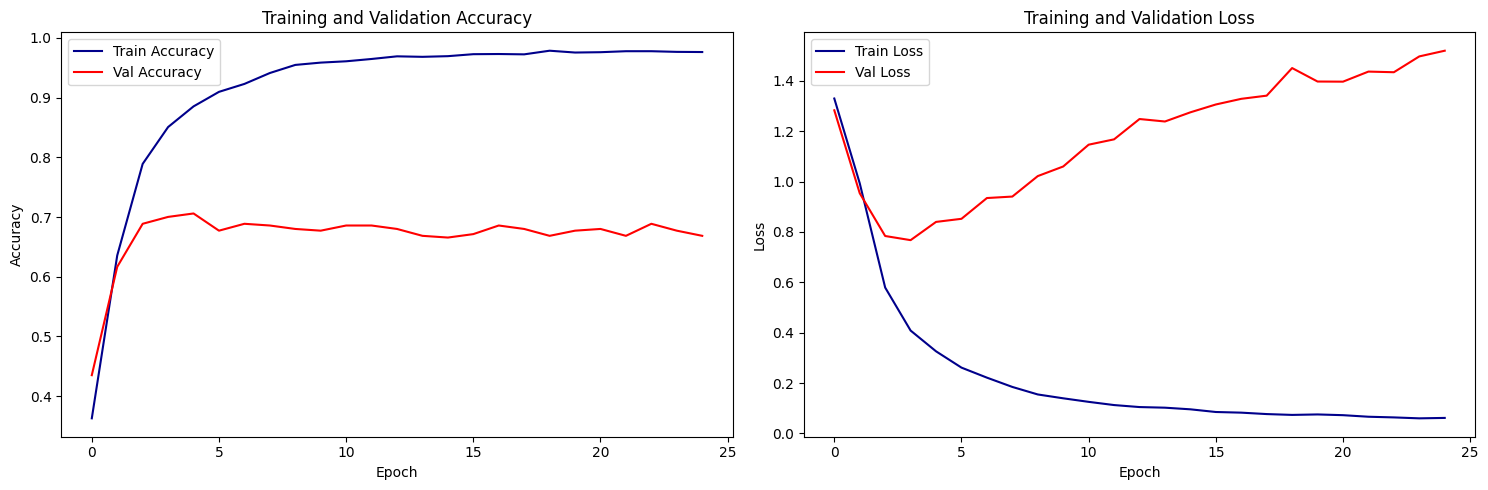

In [14]:
# Answer here

epoch = training_log['epoch'].to_numpy()
train_acc = training_log['accuracy'].to_numpy()
val_acc = training_log['val_accuracy'].to_numpy()
train_loss = training_log['loss'].to_numpy()
val_loss = training_log['val_loss'].to_numpy()

plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epoch, train_acc, label='Train Accuracy', color='darkblue',)
plt.plot(epoch, val_acc, label='Val Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epoch, train_loss, label='Train Loss', color='darkblue')
plt.plot(epoch, val_loss, label='Val Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Exercise 7
Now, we have the word vectors, but our input data is a sequence of words (or say sentence).
How can we utilize these "word" vectors to represent the sentence data and train our model?

### Answer here
需要將 `input sentence`分解成詞彙，並將每個詞彙利用wav2vec轉換為對應的向量。得到每個單詞相應的向量後，我們可以將向量組合成整個句子的表示，常見方法有以下幾種：
1. 對生成的向量們進行平均

    -> 該方法失去了詞的順序，就像BOW

2. 使用單詞向量的TF-IDF進行加權（1.的變體）

    -> 減少最常見單詞的影響

3. 使用句子的 parse tree 給予單詞向量們一個特定的順序




---
## Exercise 8
Generate a t-SNE visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total).

In [16]:
# Answer here
model_path = "GoogleNews/GoogleNews-vectors-negative300.bin.gz"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)


word_list = ['angry', 'happy', 'sad', 'fear']

topn = 15
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
sad_words = ['sad'] + [word_ for word_, sim_ in w2v_google_model.most_similar('sad', topn=topn)]
fear_words = ['fear'] + [word_ for word_, sim_ in w2v_google_model.most_similar('fear', topn=topn)]

print('angry_words: ', angry_words)
print('happy_words: ', happy_words)
print('sad_words: ', sad_words)
print('fear_words: ', fear_words)

target_words = angry_words + happy_words + sad_words + fear_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'exasperated', 'angrier', 'Angry']
happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirschbeck', 'elated', 'thankful', 'unhappy']
sad_words:  ['sad', 'saddening', 'Sad', 'saddened', 'heartbreaking', 'disheartening', 'Meny_Friedman', 'parishioner_Pat_Patello', 'saddens_me', 'distressing', 'reminders_bobbing', 'Turkoman_Shiites', 'saddest', 'unfortunate', 'sorry', 'bittersweet']
fear_words:  ['fear', 'fearful', 'fears', 'Fear', 'fearing', 'worry', 'dread', 'feared', 'anxiety', 'apprehension', 'afraid', 'worries', 'concern', 'distrust', 'worried', 'Fearful']

target words: 
['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'e

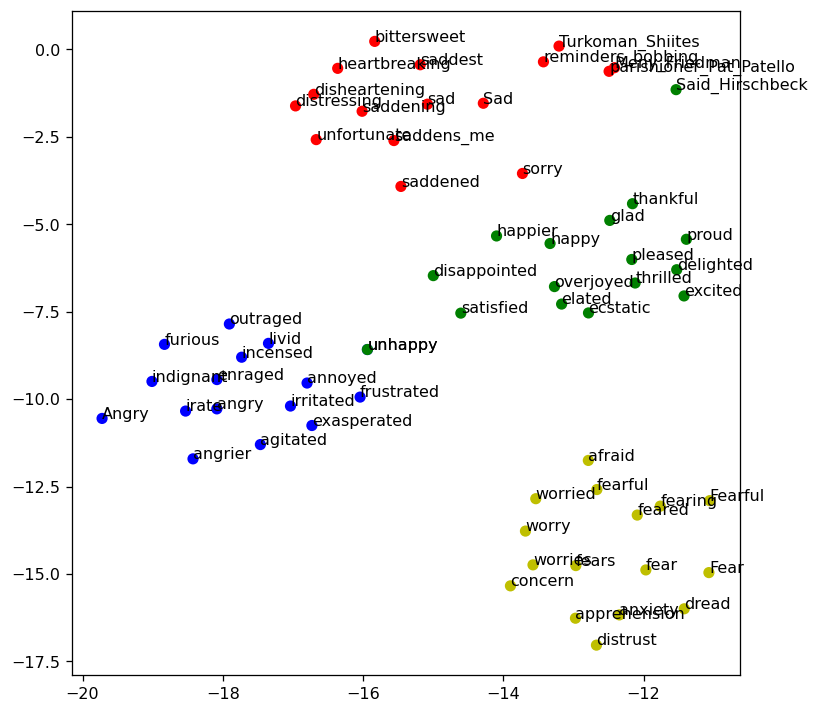

In [17]:
## w2v model
model = w2v_google_model

## prepare training word vectors (make TSNE learn more pattern)
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

# Part 2

## Load Data From Kaggle

In [ ]:
# upload  Kaggle API voucher file (kaggle.json) to colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pywang89","key":"6d05f22903cd18af7f05b805d7628f42"}'}

In [ ]:
# move the kaggle.json to the correct directory
! mkdir '/content/.kaggle/'
! cp '/content/kaggle.json' '/content/.kaggle/'
! chmod 600 '~/content/.kaggle/kaggle.json'
! kaggle datasets list

chmod: cannot access '~/content/.kaggle/kaggle.json': No such file or directory
ref                                                         title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                             DAIGT V2 Train Dataset                          29MB  2023-11-16 01:38:36           2447        223  1.0              
thedevastator/global-video-game-sales-and-ratings           Global Video Game Sales and Ratings             71KB  2023-12-20 06:46:32           1198         28  0.9411765        
muhammadbinimran/housing-price-prediction-data              Housing Price Prediction Data                  763KB  2023-11-21 17:56:32          11173        189  1.0              
henryshan/2023-data-scien

In [ ]:
# download the dataset
!kaggle competitions download -c dm2023-isa5810-lab2-homework -p '/content/drive/Shareddrives/DMLab2/DMLab2/DM2023-Lab2-Master/kaggle'
# unzip the dataset to specified directory
!unzip '/content/drive/Shareddrives/DMLab2/DMLab2/DM2023-Lab2-Master/kaggle/dm2023-isa5810-lab2-homework.zip' -d '/content/drive/Shareddrives/DMLab2/DMLab2/DM2023-Lab2-Master/kaggle'


 95% 142M/149M [00:01<00:00, 132MB/s]
100% 149M/149M [00:01<00:00, 138MB/s]
Archive:  /content/drive/Shareddrives/DMLab2/DMLab2/DM2023-Lab2-Master/kaggle/dm2023-isa5810-lab2-homework.zip
  inflating: /content/drive/Shareddrives/DMLab2/DMLab2/DM2023-Lab2-Master/kaggle/data_identification.csv  
  inflating: /content/drive/Shareddrives/DMLab2/DMLab2/DM2023-Lab2-Master/kaggle/emotion.csv  
  inflating: /content/drive/Shareddrives/DMLab2/DMLab2/DM2023-Lab2-Master/kaggle/sampleSubmission.csv  
  inflating: /content/drive/Shareddrives/DMLab2/DMLab2/DM2023-Lab2-Master/kaggle/tweets_DM.json  


## Form Dataset

###  Merge the data download from kaggle



*   `emotion.csv` -> [tweet_id, emotion]
*   `data_identification.csv` -> [tweet_id, identification]
*   `tweets_DM.json` (留下‘tweet’內資料)-> [hashtags, tweet_id, text]

Method :


1.   將數據根據 'identification' 區分 testing\training data
2.   將 'text'資料全部轉為小寫 （MODEL使用到'distilbert-base-uncased'的需求）
2.   將 'emotion'（label）接在 training data 上 並進行 label encoding   
3.   將 testing\training data 轉為 dataset型態（方便後續操作）並合併






In [23]:
# emotion.csv

emotion = pd.read_csv(data_path + "emotion.csv")

print(emotion.shape)
print(emotion.head(), "\n")

# count the frequency of each emotion label
e_count = emotion["emotion"].value_counts()

# show the distribution
print("{:<15} {:<15} {:<15}".format("Emotion", "Frequencies", "Occupy"))
print("-" * 45)
for emotion_label, count in e_count.items():
    percentage = count / emotion.shape[0] * 100
    print("{:<15} {:<15} {:.2f}%".format(emotion_label, count, percentage))

(1455563, 2)
   tweet_id       emotion
0  0x3140b1       sadness
1  0x368b73       disgust
2  0x296183  anticipation
3  0x2bd6e1           joy
4  0x2ee1dd  anticipation 

Emotion         Frequencies     Occupy         
---------------------------------------------
joy             516017          35.45%
anticipation    248935          17.10%
trust           205478          14.12%
sadness         193437          13.29%
disgust         139101          9.56%
fear            63999           4.40%
surprise        48729           3.35%
anger           39867           2.74%


In [19]:
# data_identification.csv
split = pd.read_csv(data_path + "data_identification.csv")

print(split.shape)
print(split.head(), "\n")

# count the frequency of train/test data
s_count = split["identification"].value_counts()

# show the distribution
print("{:<15} {:<15} {:<15}".format("Type", "Frequencies", "Occupy"))
print("-" * 45)
print("{:<15} {:<15} {:.2f}%".format(s_count.index[0], s_count[s_count.index[0]], (s_count[s_count.index[0]] / split.shape[0])*100))
print("{:<15} {:<15} {:.2f}%".format(s_count.index[1], s_count[s_count.index[1]], (s_count[s_count.index[1]] / split.shape[0])*100))

(1867535, 2)
   tweet_id identification
0  0x28cc61           test
1  0x29e452          train
2  0x2b3819          train
3  0x2db41f           test
4  0x2a2acc          train 

Type            Frequencies     Occupy         
---------------------------------------------
train           1455563         77.94%
test            411972          22.06%


In [20]:
# tweets_DM.json
f = open(data_path + "tweets_DM.json", "r")
lines = f.readlines()
f.close()

# convert json data to dataframe
raw_tweet = []
for line in lines:
    # 將json字串返回python物件->返回type為dict
    temp = json.loads(line)["_source"]["tweet"]
    raw_tweet.append(temp)
raw_tweet_df = pd.DataFrame(raw_tweet)

print(raw_tweet_df.shape)
print(raw_tweet_df.head())

(1867535, 3)
                        hashtags  tweet_id  \
0                     [Snapchat]  0x376b20   
1  [freepress, TrumpLegacy, CNN]  0x2d5350   
2                   [bibleverse]  0x28b412   
3                             []  0x1cd5b0   
4                             []  0x2de201   

                                                text  
0  People who post "add me on #Snapchat" must be ...  
1  @brianklaas As we see, Trump is dangerous to #...  
2  Confident of your obedience, I write to you, k...  
3                Now ISSA is stalking Tasha 😂😂😂 <LH>  
4  "Trust is not the same as faith. A friend is s...  


In [22]:
# save test data to csv

# filter out the testing data id by identification
ids = split[split["identification"] == "test"]["tweet_id"]
# pick out testing data from raw_tweet_df by id
test_data = raw_tweet_df[raw_tweet_df["tweet_id"].isin(ids)]
# transform the text data to lower case
test_data['text'] = test_data['text'].str.lower()
test_data.to_csv(data_path + "test.csv", index=False)

# save train data to csv
ids = split[split["identification"] == "train"]["tweet_id"]
train_data = raw_tweet_df[raw_tweet_df["tweet_id"].isin(ids)]

# append the emotion (answer) data to train_data
train_data_wlabel = pd.merge(train_data, emotion, on='tweet_id')

# Apply the mapping to create the 'label' column
emotion_map = {
    "joy": 0,
    "anticipation": 1,
    "trust": 2,
    "surprise": 3,
    "sadness": 4,
    "fear": 5,
    "disgust": 6,
    "anger": 7,
}
train_data_wlabel["label"] = train_data_wlabel["emotion"].map(emotion_map)
train_data_wlabel['text'] = train_data_wlabel['text'].str.lower()
train_data_wlabel.to_csv(data_path + "train.csv", index=False)
train_data_wlabel.head()

,hashtags,tweet_id,text,emotion,label
0,[Snapchat],0x376b20,"people who post ""add me on #snapchat"" must be ...",anticipation,1
1,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas as we see, trump is dangerous to #...",sadness,4
2,[],0x1cd5b0,now issa is stalking tasha 😂😂😂 <lh>,fear,5
3,"[authentic, LaughOutLoud]",0x1d755c,@riskshow @thekevinallison thx for the best ti...,joy,0
4,[],0x2c91a8,still waiting on those supplies liscus. <lh>,anticipation,1


In [ ]:
## Form the dataset
# turn pandas dataframes to datasets
train_dataset = Dataset.from_pandas(train_data_wlabel)
print(train_dataset)

test_dataset = Dataset.from_pandas(test_data)
print(test_dataset)

# combine two dataset to form the emotion dataset
tweet_emotion = DatasetDict({'train': train_dataset,'test': test_dataset})
tweet_emotion.save_to_disk(data_path + "tweet_emotion_dataset")

Dataset({
    features: ['hashtags', 'tweet_id', 'text', 'emotion', 'label', '__index_level_0__'],
    num_rows: 1455563
})
Dataset({
    features: ['hashtags', 'tweet_id', 'text', '__index_level_0__'],
    num_rows: 411972
})


Saving the dataset (0/1 shards):   0%|          | 0/1455563 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/411972 [00:00<?, ? examples/s]

## text preprocessing (Tokenize)

使用不同的 pre-trained model 時，應該使用與該 model 一起訓練的 tokenizer

-> 在這裡我們使用了 distilBERT 模型，因此應該使用distilBERT tokenizer


使用huggingface，加載不同的tokenizer 只需從 transformers 中導入 AutoTokenizer，告訴它我們使用的模型，它就會處理一切！

步驟:

1.   use AutoTokenizer to do text embeddings
2.   split out the validation data from training data



In [ ]:
# load the dataset
tweet_emotion = load_from_disk(data_path + "tweet_emotion_dataset")

In [ ]:
# load the distilBERT tokenizer using AutoTokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# use tokenizor to get sentence embeddings
def preprocess(dataslice):
    """ Input: a batch of your dataset
        Example: { 'text': [['sentence1'], ['setence2'], ...] }
    """
    embeddings = tokenizer(dataslice['text'])
    dataslice.update(embeddings)
    return dataslice

    """ Output: a batch of processed dataset
        Example: { 'text': ...,
                   'input_ids': ...,
                   'attention_masks': ...,}

    """

In [ ]:
# map the function to the whole dataset
tweet_emotion_processed = tweet_emotion.map(preprocess,    # processing function
                             batched = True # Process in batches so it can be faster
                            )

In [ ]:
# choose a validation size and split the training dataset
train_val_dataset = tweet_emotion_processed['train'].train_test_split(test_size=0.2)
print(train_val_dataset)

DatasetDict({
    train: Dataset({
        features: ['hashtags', 'tweet_id', 'text', 'emotion', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1164450
    })
    test: Dataset({
        features: ['hashtags', 'tweet_id', 'text', 'emotion', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 291113
    })
})


## Training

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=8)

# declare a collator to do padding during traning
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#  set and tune training properties

# set more parameters
output_dir = './model'
learning_rate = 2e-5
batch_size = 64
epoch = 3
weight_decay = 0.01

training_args = TrainingArguments(
    output_dir = output_dir,
    learning_rate = learning_rate,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = epoch,
    weight_decay = weight_decay

)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=8)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    total = predictions.shape[0]
    correct = 0
    for i in range(total):
        if predictions[i] == labels[i]:
            correct += 1
    return {'accuracy': correct / total, 'correct': correct}

# give all the information to a trainer
trainer = Trainer(
    model_init  = model_init,
    args = training_args,
    data_collator = data_collator,
    train_dataset = train_val_dataset['train'],
    eval_dataset = train_val_dataset['test'],
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# model training
# trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,1.507900
1000,1.312600
1500,1.239300
2000,1.200500
2500,1.154900
3000,1.133000
3500,1.139300
4000,1.115200
4500,1.095800
5000,1.094500


Checkpoint destination directory ./model_4/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./model_4/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=36390, training_loss=1.0012028269860795, metrics={'train_runtime': 10173.5337, 'train_samples_per_second': 228.918, 'train_steps_per_second': 3.577, 'total_flos': 3.237778845955661e+16, 'train_loss': 1.0012028269860795, 'epoch': 2.0})

In [ ]:
# model training
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,1.520800
1000,1.318700
1500,1.239400
2000,1.193500
2500,1.159700
3000,1.145000
3500,1.132100
4000,1.115200
4500,1.108800
5000,1.093800


TrainOutput(global_step=54585, training_loss=0.9468643976784434, metrics={'train_runtime': 5385.2411, 'train_samples_per_second': 648.69, 'train_steps_per_second': 10.136, 'total_flos': 4.860451445848589e+16, 'train_loss': 0.9468643976784434, 'epoch': 3.0})

In [ ]:
# trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,1.527200
1000,1.319200
1500,1.239600
2000,1.196600
2500,1.168600
3000,1.142500
3500,1.128100
4000,1.117400
4500,1.108900
5000,1.090200


TrainOutput(global_step=90975, training_loss=0.8566009633860178, metrics={'train_runtime': 8832.5841, 'train_samples_per_second': 659.179, 'train_steps_per_second': 10.3, 'total_flos': 8.098700083881773e+16, 'train_loss': 0.8566009633860178, 'epoch': 5.0})

In [ ]:
# save the  model
trained_model_name = f"{MODEL_NAME}_epoch{str(epoch)}_lrate_{str(learning_rate)}"
model.save_pretrained(os.path.join('model_3', trained_model_name))

## Make predictions

使用訓練好的模型對 testing data 進行預測並將結果寫成`submission.csv` 上傳至kaggle

In [ ]:
# Proceed with predictions
predictions = trainer.predict(tweet_emotion_processed['test'])
print(predictions)

# Access prediction values
pred = np.argmax(predictions.predictions, axis=-1)
print(pred.shape)

PredictionOutput(predictions=array([[ 2.7531667 ,  3.9448667 ,  2.8525865 , ..., -2.2587764 ,
        -4.1623    , -4.138759  ],
       [ 0.7703398 ,  2.9719834 ,  4.5356264 , ..., -1.7094687 ,
        -3.8376353 , -4.570314  ],
       [ 2.819437  ,  2.223284  ,  1.1968062 , ..., -2.6508582 ,
        -2.2156448 , -2.7447112 ],
       ...,
       [ 0.0172335 , -0.09300034, -1.3451153 , ..., -1.5367314 ,
         0.812811  , -0.17990515],
       [ 1.8435117 , -0.16137423,  0.8304343 , ..., -2.2523284 ,
        -0.47696942, -0.14384528],
       [-1.9344393 , -0.13613346, -2.3216352 , ..., -1.4884375 ,
         0.87891996,  1.7042438 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 530.9576, 'test_samples_per_second': 775.904, 'test_steps_per_second': 12.125})
(411972,)


In [ ]:
# Read test.csv  and  append predicted result
sub_csv = pd.read_csv(data_path + "test.csv", lineterminator='\n')
emotion_list = list(emotion_map.keys())
emotions = [emotion_list[x] for x in pred]
sub_csv["emotion"] = emotions
sub_csv.drop(["hashtags", "text"], axis=1, inplace=True)
sub_csv.columns = ["id", "emotion"]
sub_csv.to_csv("submission.csv", index=False)

print(sub_csv.head(20))

          id       emotion
0   0x28b412  anticipation
1   0x2de201         trust
2   0x218443           joy
3   0x2939d5  anticipation
4   0x26289a         trust
5   0x31c6e0       disgust
6   0x32edee           joy
7   0x3714ee       sadness
8   0x235628           joy
9   0x283024       sadness
10  0x25dcd8           joy
11  0x33df6e           joy
12  0x2d6cb6       sadness
13  0x21d36a           joy
14  0x34fc3e           joy
15  0x338b96           joy
16  0x38895c           joy
17  0x260d2b       sadness
18  0x38c20a           joy
19  0x21ee14           joy


# Part 3



## 模型選擇：
在實驗過程中，發現使用 Scikit-Learn 建構的 model（嘗試了RandomForest 以及 Naive Bayes），並無法取得較好的預測結果。該情況即使進行資料前處理、調整參數仍無法改善。**（分數不到0.5）**

-> 因此，改採用 hugging face 上的大型語言模型作為競賽使用。

總共嘗試了三個模型：

*   **distilbert-base-uncased**：

    輕量的BERT，只有一半的層數。使用knowledge distillation的方式進行訓練，以達到與BERT相似的結果。

*   **bert-large-uncased**：

    BERT的較大版本。
*  **cardiffnlp/twitter-roberta-base-emotion**：

    同樣基於BERT架構，並在大量推特數據上進行預訓練。由於訓練數據都是推特文，表現可能會比前二者更好。

###-> 實驗結果：
bert-large-uncased以及twitter-roberta-base-emotion模型由於過大，訓練時間被拉得很長，且訓練過程記憶體容易爆掉，最終結果以**distilbert**為主。接下來討論也會聚焦在該模型上。






##  資料前處理：


###A. 資料合併：



*   `emotion.csv` -> [tweet_id, emotion]
*   `data_identification.csv` -> [tweet_id, identification]
*   `tweets_DM.json` (留下‘tweet’內資料)-> [hashtags, tweet_id, text]

### Method :


1.   將數據根據 'identification' 區分 testing\training data

    ```
    ids = split[split["identification"] == "test"]["tweet_id"]
    test_data = raw_tweet_df[raw_tweet_df["tweet_id"].isin(ids)]
    ```

    ```
    ids = split[split["identification"] == "train"]["tweet_id"]
    train_data = raw_tweet_df[raw_tweet_df["tweet_id"].isin(ids)]
    ```
2.   將 'emotion'（label）接在 training data 上 並進行 label encoding  

    ```
    train_data_wlabel = pd.merge(train_data, emotion, on='tweet_id')

    # Apply the mapping to create the 'label' column
    emotion_map = {
        "joy": 0,
        "anticipation": 1,
        "trust": 2,
        "surprise": 3,
        "sadness": 4,
        "fear": 5,
        "disgust": 6,
        "anger": 7,
    }
    train_data_wlabel["label"] = train_data_wlabel["emotion"].map(emotion_map)
```
3.   ( text 前處理後)將 testing\training data 轉為 dataset型態（方便後續操作）並合併

    ```
    train_dataset = Dataset.from_pandas(train_data_wlabel)

    test_dataset = Dataset.from_pandas(test_data)

    tweet_emotion = DatasetDict({'train': train_dataset,'test': test_dataset})
    ```
---
###B. text前處理：

  由於 BERT 是大型語言模型，已使用大量文字資料進行預訓練。過多的前處理可能會刪除掉可能增加正確率的資訊，因此不考慮刪去 stop words，符號部分僅處理 '＠username' 以及網址內容，此外由於模型是 'uncased' 因此需將所有文字內容轉為小寫。處理方式如下：
```
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = t.lower()
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

test_data['text'] = test_data['text'].apply(preprocess)
train_data_wlabel['text'] = train_data_wlabel['text'].apply(preprocess)
```

###-> 實驗結果：
結果發現**準確率在僅將所有文字轉為小寫時最高**，可見 username 以及網址內容有時候可能也包含了情緒判別的資訊。最後使用:
```
   test_data['text'] = test_data['text'].str.lower()
   train_data_wlabel['text'] = train_data_wlabel['text'].str.lower()
```
進行所有 twitter 文字內容的調整。

---
### C. Tokenizer (標記器)

使用不同的 pre-trained model 時，應該使用與該 model 一起訓練的 tokenizer

-> 使用了 distilBERT 模型，應該使用distilBERT tokenizer


使用huggingface，加載不同的tokenizer 只需從 transformers 中導入 AutoTokenizer，告訴它我們使用的模型，它就會處理一切！

###Method:

1.   use `AutoTokenizer` to do text embeddings
    ```
    MODEL_NAME = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    ```
    這裡我們在定義一個function讓我們可以批次處理，更快完成 embeddings

    ```
    def preprocess(dataslice):
        embeddings = tokenizer(dataslice['text'])
        dataslice.update(embeddings)
        return dataslice
    ```

    Input Example: {'text': [['sentence1'], ['setence2'], ...] }

    Output Example: { 'text': ...,'input_ids': ...,'attention_masks': ...,}


2.   split out the validation data from training data (0.2-> validation, 0.8-> training)
      ```
      train_val_dataset = tweet_emotion_processed['train'].train_test_split(test_size=0.2)
      ```

## 參數調整：
定義好參數之後就可以進行模型的訓練！
使用到的訓練參數：
```
learning_rate = 2e-5
batch_size = 64
epoch = 3
weight_decay = 0.01
```
將所有定義的參數丟入Trainer：
```
training_args = TrainingArguments(
    output_dir = output_dir,
    learning_rate = learning_rate,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = epoch,
    weight_decay = weight_decay

)
trainer = Trainer(
    model_init  = model_init,
    args = training_args,
    data_collator = data_collator,
    train_dataset = train_val_dataset['train'],
    eval_dataset = train_val_dataset['test'],
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
)
```
執行```trainer.train()```就可以進行訓練了！

###-> 實驗結果：
嘗試了很多learning rate 和 epoch的組合。由於 colab 環境 epoch 開太大會無法負荷，所以將每次訓練後的model存起來，在進行新一輪的訓練！

在過程中發現在```distilbert-base-uncased```之下，epoch調高雖然會讓 training loss下降：

* epoch = 10 -> training loss = 0.651
* epoch = 5 -> trianing loss = 0.857
* epoch = 3 -> training loss = 0.947
* epoch = 2 -> training loss = 1.001

但之後在 testing dataset 的表現並不會因此提升！epoch 數越高，分數甚至越低ＱＱ

最後發現 ```learning_rate = 2e-5``` 、```epoch = 3```之下的預測結果最為優秀（0.549）。